# Homework 4
Samarth Kumar (szk0187)

---

Import dependencies

In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler

## Question 1

Load and preprocess dataset.

In [3]:
# Load the dataset from UCI ML Repository
wine_quality = fetch_ucirepo(id=186)
X = wine_quality.data.features
y = wine_quality.data.targets

X = X.to_numpy()
y = y.to_numpy()

# Convert to binary classification (good vs bad wine)
y = np.where(y > 5, 1, 0)

# Split test/train
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

### (a)

Normalize the data

In [4]:
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
xTest_scaled = scaler.transform(xTest)

Train unregularized Logistic Regression model

In [5]:
lr = LogisticRegression(penalty=None)
lr.fit(xTrain_scaled, yTrain)
yPred = lr.predict_proba(xTest_scaled)[:, 1]
print(f"AUC Score: {roc_auc_score(yTest.ravel(), yPred.ravel())}")

AUC Score: 0.7776515477971999


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
print(classification_report(yTest, lr.predict(xTest_scaled)))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59       451
           1       0.78      0.80      0.79       849

    accuracy                           0.72      1300
   macro avg       0.69      0.69      0.69      1300
weighted avg       0.72      0.72      0.72      1300



Overall accuracy of 72% when training Logistic Regression on the normalized data.

### (b) PCA On Normalized Training Set

In [7]:
pca = PCA(n_components=None)
pca.fit(xTrain_scaled)
pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [8]:
pca = PCA().fit(xTrain_scaled)
cumulativeVariance = np.cumsum(pca.explained_variance_ratio_)
numComponents = np.argmax(cumulativeVariance >= 0.95) + 1
print(f"{numComponents} components capture at least 95% of the variance in original dataset.")

9 components capture at least 95% of the variance in original dataset.


In [9]:
feature_names = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide",
    "density", "pH", "sulphates", "alcohol"
]

for idx in range(3):
    loadings = pca.components_[idx]
    top_idx = np.argsort(np.abs(loadings))[::-1][:3]
    print(f"\nPrincipal Component #{idx+1}) # (explained variance ratio = {pca.explained_variance_ratio_[idx]:.2%}):")
    for i in top_idx:
        print(f"- Feature: {feature_names[i]:<20s} (Loading = {loadings[i]:+.3f})")


Principal Component #1) # (explained variance ratio = 27.60%):
- Feature: total sulfur dioxide (Loading = +0.488)
- Feature: free sulfur dioxide  (Loading = +0.435)
- Feature: volatile acidity     (Loading = -0.377)

Principal Component #2) # (explained variance ratio = 22.65%):
- Feature: density              (Loading = +0.584)
- Feature: alcohol              (Loading = -0.464)
- Feature: residual sugar       (Loading = +0.338)

Principal Component #3) # (explained variance ratio = 14.21%):
- Feature: citric acid          (Loading = +0.594)
- Feature: pH                   (Loading = -0.457)
- Feature: fixed acidity        (Loading = +0.431)


So the first principal component involves total sulfur dioxide, free sulfur dioxide, and volatile acidity. The loadings for total sulfur dioxide and free sulfur dioxide are strong and positive, while volatile acidity is strong negative.

The second component involves density, alcohol, residual sugar. Density and residual sugar demonstrate a strong positive loading while alcohol is strong negative.

The third component consists of citric acid, pH level, and fixed acidity. Citric acid and fixed acidity demonstrate a strong positive loading while pH level is strong negative.

Together, these first 3 principal components account for a 64.46% explained variance ratio.

### (c) Use NMF

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


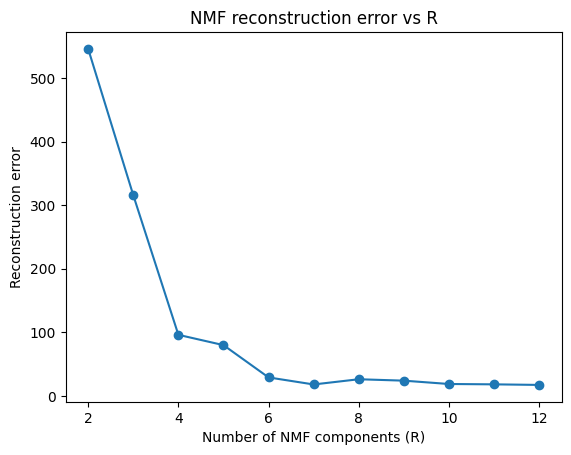

In [10]:
errors = []
components = range(2, 13)
for r in components:
    nmf = NMF(n_components=r, init='random', random_state=42, max_iter=500)
    nmf.fit(xTrain)
    errors.append(nmf.reconstruction_err_)

plt.plot(components, errors, marker='o')
plt.xlabel("Number of NMF components (R)")
plt.ylabel("Reconstruction error")
plt.title("NMF reconstruction error vs R")
plt.show()

Using NMF, the R value should be 6. When looking at the graph above, the steepest drop in error happens from R values 2 to 4, and the second steepest drop is from R values 5 to 6. When R > 6, there are only very minimal drops in the error. So I will choose **R = 6**

### (d) Logistic Regression Models

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


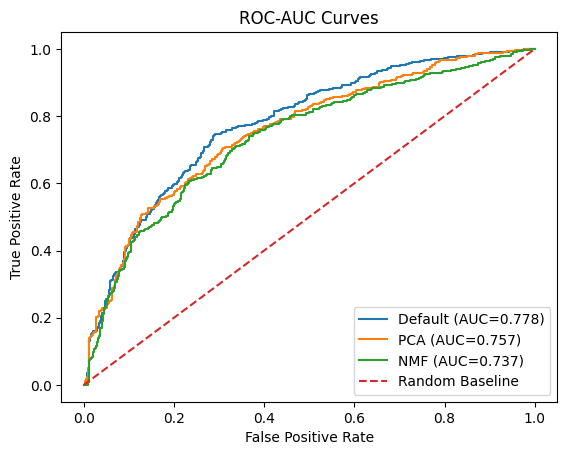

In [11]:
# Initialize PCA and NMF using the R value I selected (6).
pca = PCA(n_components=6, random_state=42)
nmf = NMF(n_components=6, init='random', random_state=42)

# Creating a dictionary to store the data and predictions for default, PCA, and NMF models. This will be helpful for looping through the data to create the plots efficiently.
datasets = {
    "Default": (xTrain_scaled, xTest_scaled),
    "PCA":  (pca.fit_transform(xTrain_scaled), pca.transform(xTest_scaled)),
    "NMF":  (nmf.fit_transform(xTrain), nmf.transform(xTest))
}

# Create the plots for default, PCA, and NMF by looping through the datasets.
plt.figure()
for name, (trainx, testx) in datasets.items():
    lr = LogisticRegression(random_state=42, penalty=None)
    lr.fit(trainx, yTrain)
    preds = lr.predict_proba(testx)[:, 1]
    falsePos, truePos, _ = roc_curve(yTest, preds)
    score = auc(falsePos, truePos)
    plt.plot(falsePos, truePos, label=f"{name} (AUC={score:.3f})")

# Baseline
plt.plot([0, 1], [0, 1], '--', label="Random Baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves")
plt.legend()
plt.show()


All three approaches clearly outperformed random guessing (AUC of 0.5 roughly). The highest AUC of 0.778 occurred when training the model on the original dataset. When using PCA, the AUC of 0.757 was pretty close, so limiting the features to 9 components was able to capture most of the variance. Using NMF, however, reduced the AUC even more, to 0.737, showing that it was less optimal for the classification task on this given dataset. But, aside from the specific AUC values, all three ROC-AUC curves followed a very similar trend.






## Question 2

### (a)

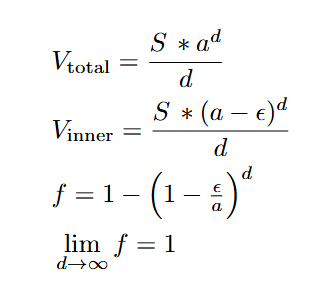

### (b) Plot

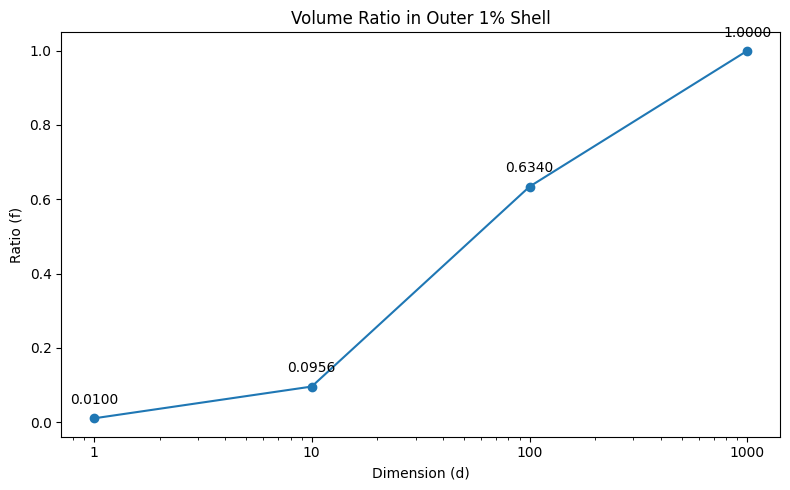

In [12]:
# Parameters
dimensions = [1, 10, 100, 1000]
epsilon = 0.01

# Compute the ratio for each dimension
ratio = [1 - (1 - epsilon)**d for d in dimensions]

# Plot the ratio at each dimension.
plt.figure(figsize=(8, 5))
plt.plot(dimensions, ratio, marker='o')
plt.xscale('log')
plt.xticks(dimensions, dimensions)
plt.title('Volume Ratio in Outer 1% Shell')
plt.xlabel('Dimension (d)')
plt.ylabel('Ratio (f)')

for d, r in zip(dimensions, ratio):
  plt.text(d, r + 0.03, f'{r:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### (c) Conclusion

Plotting the fraction 1- (1- $\epsilon$ )^d against dimension d for $\epsilon$ = 0.01:
* d = 1: 1% of the volume being within the outer 1%.
* d = 10: 9.56% of the volume being within the outer 1%.
* d = 100: 63.4% of the volume being within the outer 1%.
* d = 100: 100% of the volume being within the outer 1%.

This shows, when the space is high-dimensional, pretty much all of the volume is confined to a very thin boundary layer, hence the curse of dimensionality.
